In [46]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from copy import deepcopy

from scipy import stats


In [47]:
# Minimum stake = Penalty
SupplierMinStake = 2e3 # POKT
# Total POKT that can be claimed without requiering mandatory proof
ProofRequirementThreshold = 20 # POKT
# Probability that a claim below the threshold will requiere proof
ProofRequestProbability = 0.001

In [48]:
# This is the expected number of claims before being requested for a proof
# According to https://en.wikipedia.org/wiki/Geometric_distribution (mode 0)
E_false_claims_before_proof = (1-ProofRequestProbability) / ProofRequestProbability

# For ease calculations we will use the scipy implementation 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html

# Here we show that both achieve the same mean, more testing in the appendix
print(f"Expected claims passed before begin requiederd a proof: {E_false_claims_before_proof} (same with scypi: {stats.geom.mean(ProofRequestProbability, loc=-1)})")

Expected claims passed before begin requiederd a proof: 999.0 (same with scypi: 999.0)


The integral of the PMF is de CDF wich tells us the proportion of the total draws that we expect to see below a given threshold in the support of the PDF.

The CDF has domain on the same as the PDF and codomain is the total sample proportion below that domain point.


In [49]:
coverage_of_mean = stats.geom.cdf(E_false_claims_before_proof, ProofRequestProbability, loc=-1)
print(f"The expected number claims passed before begin requiederd a proof represents a coverage of {coverage_of_mean*100:.2f}%")
print(f"This means that {(1-coverage_of_mean)*100:.2f}% of the trials will pass MORE claims before being requieres a proof")

The expected number claims passed before begin requiederd a proof represents a coverage of 63.23%
This means that 36.77% of the trials will pass MORE claims before being requieres a proof


So we want to go the other way arround, we want to know the value in the domain of the CDF that give us an specific value in the codomain.

More simply, we want to answer: To have X% of samples included, wich is the value that I must select?

and specific to our problem: In 95% of all trials, which is the number of claims we expect to pass before a proof is enforced?

The answer to this is the [quantile function](https://en.wikipedia.org/wiki/Quantile_function) or the percent point function, provided in scypi as `ppf`:


In [50]:
COVERAGE = 0.95
E_false_claims_before_proof_COVERAGE = int(stats.geom.ppf(0.95, ProofRequestProbability, loc=-1))

print(f"In the {COVERAGE*100:0.2f}% of the trials, the number of claims that pass before requiering a proof is lower than {E_false_claims_before_proof_COVERAGE}")

print(f"(Just to check, these two should be simmilar: {stats.geom.cdf(E_false_claims_before_proof_COVERAGE, ProofRequestProbability, loc=-1):0.2f} , {COVERAGE:0.2f})")

In the 95.00% of the trials, the number of claims that pass before requiering a proof is lower than 2994
(Just to check, these two should be simmilar: 0.95 , 0.95)


Now lets test what happens when we use either the expected valu or the selected number of trials for a given coverage (through using the PPF)

In [51]:
# Slashing according to the selected coverage
Slash_COVERAGE = int(E_false_claims_before_proof_COVERAGE*ProofRequirementThreshold)
Slash_E = int(E_false_claims_before_proof*ProofRequirementThreshold)

print(f"The slashing for:\n\tExpected trials:\t\t {Slash_E}\n\t{COVERAGE*100:0.2f}% coverage of trials:\t {Slash_COVERAGE}")

The slashing for:
	Expected trials:		 19980
	95.00% coverage of trials:	 59880


In [58]:
# We can can also calcualte the PPF using a simple loop:
def cdf_theo(x,p):
    # theoretical CFG
    return 1.0-((1.0-p)**(np.floor(x)+1.0))
current_coverage = 0
current_trials = 0
while current_coverage < COVERAGE:
    current_trials += 1.0 # This can be much coarse if we want
    current_coverage  = cdf_theo(current_trials, ProofRequestProbability)

print(f"The number of trials for {100*current_coverage:0.2f}% is {int(current_trials)}")

The number of trials for 95.00% is 2994


# Numerical Simulation

But lets not belive and test is the hard way... through sampling...

In [7]:
# This is the number of times that the attacker will engage in sending fake claims
samples = 1e8

In [8]:
# So we run this though the geometrical distribution, sampling from it directly.
# It will return the number of fake claims that passed before the attacker was requested a proof.
attackers_sample = stats.geom.rvs(ProofRequestProbability, loc=-1, size=int(samples), random_state=1)

In [9]:
# Now we calculate the proffit of the attacker, that will be equal to the number
# of samples passed before the requested proof, multiplied by the maximum reward
# that can be claimed without mandatory proof and minus the slashing of the 
# missing proof
attacker_proffit_E = np.sum(ProofRequirementThreshold*attackers_sample)-samples*Slash_E
attacker_proffit_COVERAGE = np.sum(ProofRequirementThreshold*attackers_sample)-samples*Slash_COVERAGE

print(f"The total proffit/cost of the attacker will be:\n\tExpected trials coverage {attacker_proffit_E}\n\t{COVERAGE*100:0.2f}% coverage of trials:{attacker_proffit_COVERAGE}")
print("We can see that the attacker actually made proffit!")

The total proffit/cost of the attacker will be:
	Expected trials coverage 358130120.0
	95.00% coverage of trials:-3989641869880.0
We can see that the attacker actually made proffit!


In [10]:
# While I cheatead a little by setting the seed to a case where this happens, it 
# is only to highlight that using the expected number of trials is bad coverage.
# Why? because the expected proffit is zero, but the variance is high

# This is the average cost (per trial) for the attacker is very near zero
attacker_average_per_attack_proffit_E = attacker_proffit_E/samples
attacker_average_per_attack_proffit_COVERAGE = attacker_proffit_COVERAGE/samples

print(f"This is an average proffit/cost per trial of:\n\tExpected trials coverage {attacker_average_per_attack_proffit_E}\n\t{COVERAGE*100:0.2f}% coverage of trials:{attacker_average_per_attack_proffit_COVERAGE}")

This is an average proffit/cost per trial of:
	Expected trials coverage 3.5813012
	95.00% coverage of trials:-39896.4186988


In [11]:
# We can suspect this by looking at the standard deviation
print(f"Standard deviation of the number of claims before proof requiered: {np.std(attackers_sample, ddof=1):0.2f} (or mathematically: {np.sqrt((1-ProofRequestProbability)/(ProofRequestProbability**2)):0.2f})")


Standard deviation of the number of claims before proof requiered: 999.81 (or mathematically: 999.50)


Since we know that the distribution domain is only positive integers, having a standard deviation larger than the expected value gives us the intuition that the odds for a profitable attack are not in our favor. In other words, it is possible (not probable) to claim a VERY large number of claims before being requiered a proof, but is not possible to be requiered a proof with less than 1 fake claim.

By using a larger coverage we set the per-trial proffit negative (by a given margin) and hence the variations expected from this non-normal distribtion cannot ever offset this negativity, resulting in a negative proffit for all but the extreme cases.

Finally we can see this in the shape of the distribution that is packed near zero but there is a long tail of trials with very high rewards for the atacker.

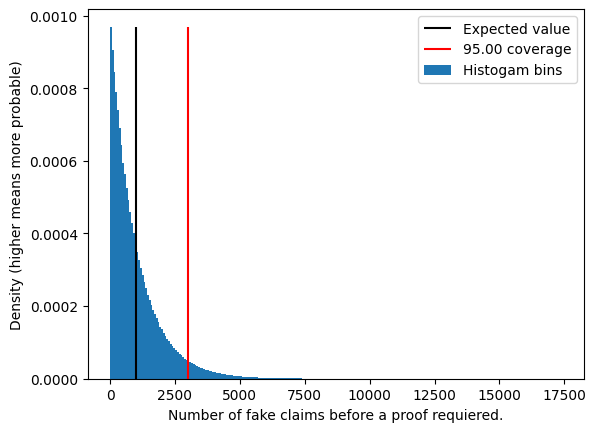

In [12]:
plt.figure(dpi=100)
b = plt.hist(attackers_sample, bins=256, density=True)
plt.vlines([E_false_claims_before_proof], ymax=np.max(b[0]), ymin=0, colors=["black"])
plt.vlines([E_false_claims_before_proof_COVERAGE], ymax=np.max(b[0]), ymin=0, colors=["red"])
plt.xlabel("Number of fake claims before a proof requiered.")
plt.ylabel("Density (higher means more probable)")
plt.legend(["Expected value", f"{COVERAGE*100:0.2f} coverage", "Histogam bins"])
plt.show()


# Appendix

Just to show that scipy is the same as used math in the PR

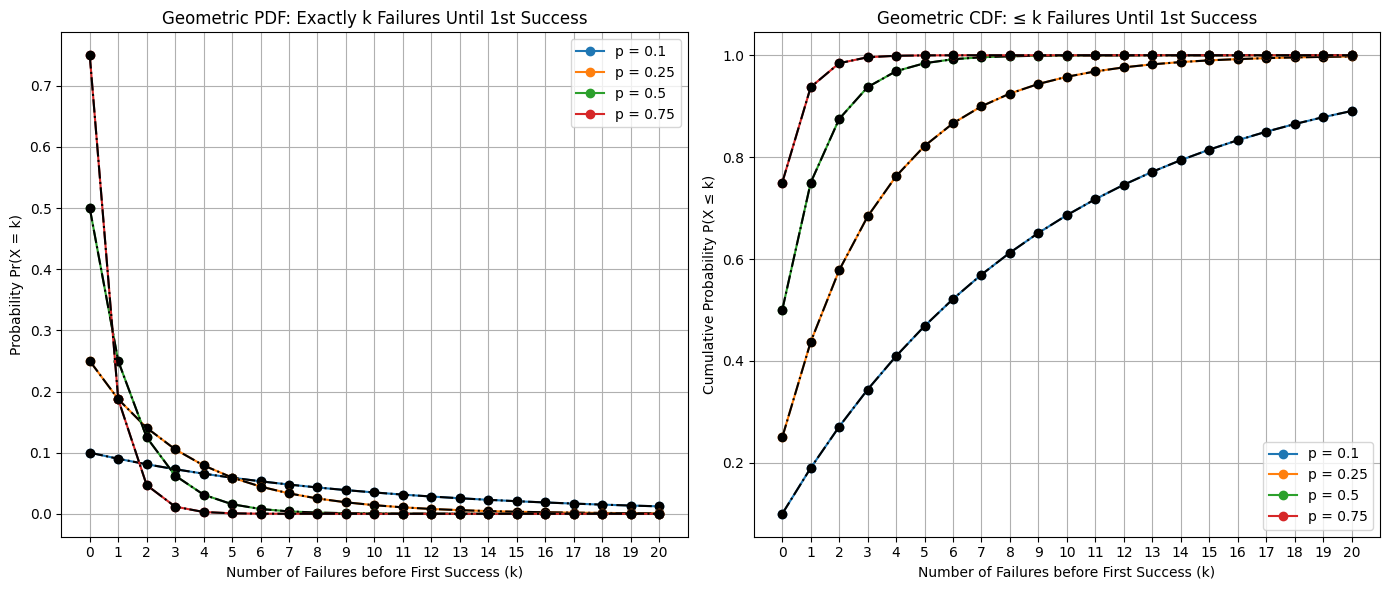

In [13]:
p_values = [0.1, 0.25, 0.5, 0.75]  # Modify as needed
k_values = np.arange(0, 21)  # Range of k values starting from 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Plot Geometric PDF for different p values
for p in p_values:
    q = 1 - p
    pdf_values = p * (1 - p) ** k_values
    ax1.plot(k_values, pdf_values, marker="o", linestyle="-", label=f"p = {p}")

    pdf_geom = stats.geom.pmf(k_values, p, loc=-1)
    ax1.plot(k_values, pdf_geom, marker="o", linestyle="-.", color="black")
    # pdf_nbin = stats.nbinom.pmf(k_values, 1, p)
    # ax1.plot(k_values, pdf_nbin, marker="o", linestyle="-.", color="black")

ax1.set_title("Geometric PDF: Exactly k Failures Until 1st Success")
ax1.set_xlabel("Number of Failures before First Success (k)")
ax1.set_ylabel("Probability Pr(X = k)")
ax1.set_xticks(k_values)
ax1.grid(True)
ax1.legend()

# Plot Geometric CDF for different p values
for p in p_values:
    q = 1 - p
    cdf_values = 1 - (1 - p) ** (k_values + 1)
    ax2.plot(k_values, cdf_values, marker="o", linestyle="-", label=f"p = {p}")

    cdf_geom = stats.geom.cdf(k_values, p, loc=-1)
    ax2.plot(k_values, cdf_geom, marker="o", linestyle="-.", color="black")

ax2.set_title("Geometric CDF: ≤ k Failures Until 1st Success")
ax2.set_xlabel("Number of Failures before First Success (k)")
ax2.set_ylabel("Cumulative Probability P(X ≤ k)")
ax2.set_xticks(k_values)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


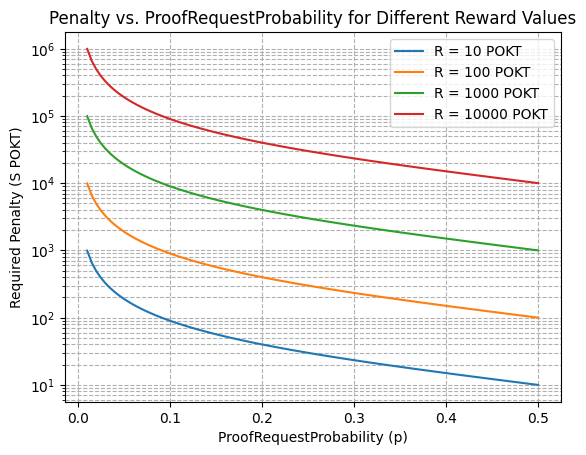

In [14]:
p_values = np.linspace(0.01, 0.5, 100)
R_values = [10, 100, 1000, 10000]

for R in R_values:
    # S_values = R * ((1 - p_values) / p_values)
    S_values = R * stats.geom.mean(p_values,loc=-1)
    plt.plot(p_values, S_values, label=f"R = {R} POKT")

plt.xlabel("ProofRequestProbability (p)")
plt.ylabel("Required Penalty (S POKT)")
plt.title("Penalty vs. ProofRequestProbability for Different Reward Values")
plt.legend()
plt.yscale("log")  # Use logarithmic scale for y-axis (optional)
plt.grid(True, which="both", ls="--")
plt.show()